In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime

In [2]:
class Linear_Auto_Encoder(nn.Module):
    def __init__(self,nb_channels,nb_encoded_features,patch_size = (16,16,16)):
        nn.Module.__init__(self)
        self.nb_channels = nb_channels
        self.nb_encoded_features = nb_encoded_features
        self.patch_size = patch_size
        self.encode_linear = nn.Linear(in_features = patch_size[0]*patch_size[1]*patch_size[2],out_features = nb_encoded_features)
        self.decode_linear = nn.Linear(in_features = nb_encoded_features,out_features = patch_size[0]*patch_size[1]*patch_size[2])
    
    def forward(self,x):
        x = x.view(x.size()[0],-1)
        #x = F.relu(x)
        encoded = self.encode_linear(x)
        x = self.decode_linear(encoded)
        #x = F.relu(x)
        x = x.view((x.size()[0],) + (self.nb_channels,) + self.patch_size)
        return x

In [3]:
def train_AE(AE,epochs = 2000, batch_size = 1):
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(AE.parameters())
    start_time = datetime.datetime.now()
    losses = []
    torch.set_num_threads(8)
    for epoch in range(epochs+1):
        #load data
        N_train = 0.5 * len(os.listdir('Euler_Displacement'))
        inputs = np.zeros((batch_size,) + (AE.nb_channels,) + AE.patch_size)
        for i in range(batch_size):
            idx = np.random.randint(0,N_train)
            img = np.load('Euler_Displacement/' + os.listdir('Euler_Displacement')[idx])
            #img = img.reshape((AE.nb_channels,) + AE.img_size)
            x = np.random.randint(0,240)
            patch = img[x:x+16,x:x+16,x:x+16]
            patch = patch.reshape((AE.nb_channels,) + AE.patch_size)
            inputs[i] = patch
        
        inputs = torch.Tensor(inputs)
        #Gradient set to zero
        optimizer.zero_grad()
        
        # forward + backward 
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #print(device)
        AE = AE.to(device)
        inputs = inputs.to(device)
        outputs = AE(inputs)
        loss = criterion(outputs, inputs)
        loss.backward() 
        
        #update parameters
        optimizer.step()
        
        losses.append(loss.item())
        if(epoch%100 ==0):
            print(loss.item())
            print(datetime.datetime.now() - start_time)
    
    np.save('history.npy',np.array(losses))

In [4]:
LAE = Linear_Auto_Encoder(nb_channels = 1, nb_encoded_features = 4)

In [5]:
train_AE(LAE,batch_size = 4)

295.2695617675781
0:00:04.783645
18.642105102539062
0:00:33.485858
50.65137481689453
0:01:03.295548
88.203125
0:01:33.947880
78.27971649169922
0:02:03.057000
79.52896118164062
0:02:30.606908
13.540297508239746
0:02:58.776605
32.509525299072266
0:03:26.444593
25.62362289428711
0:03:57.766196
3.42462158203125
0:04:26.927028
3.096296787261963
0:04:54.762315
3.2072649002075195
0:05:22.583298
0.6248839497566223
0:05:53.060962
4.031173229217529
0:06:20.849627
0.19848045706748962
0:06:48.804590
0.26483333110809326
0:07:17.221045
0.19855105876922607
0:07:44.747744
0.41871869564056396
0:08:12.985365
0.12816458940505981
0:08:44.933144
0.1728428602218628
0:09:13.348623
0.08704166114330292
0:09:41.598909


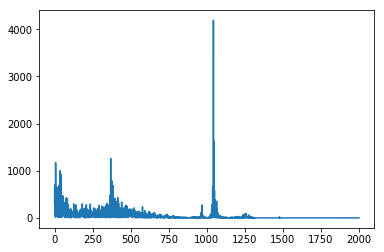

In [6]:
history = np.load('history.npy')
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history)

In [8]:
testset = []
for idx in range(110,190):
    img = np.load('Euler_Displacement/' + os.listdir('Euler_Displacement')[idx])
    x = np.random.randint(0,240)
    patch = img[x:x+16,x:x+16,x:x+16]
    testset.append(patch)
    
testinput = np.array(testset)
testinput = testinput.reshape((80*4096,))
print(np.var(testinput))
testinput = testinput.reshape((80,1,16,16,16))
testinput = torch.Tensor(testinput)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
testinput = testinput.to(device)
testoutput = LAE(testinput)
criterion = nn.MSELoss()
loss = criterion(testoutput, testinput)
print(loss)

76.33455380204762
tensor(0.2201, device='cuda:0', grad_fn=<MseLossBackward>)


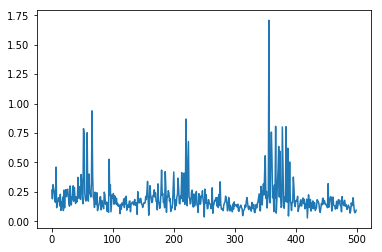

In [9]:
plt.plot(history[1500:2000])